In [ ]:
import os
import sys
import cv2
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet_v2 import preprocess_input, ResNet152V2 
from tensorflow.keras.layers import Bidirectional, TimeDistributed, GRU, Dense, Input, Layer, GlobalAveragePooling2D

In [ ]:
!pip freeze > requirements.txt

# Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Video zip

In [ ]:
!gdown --id 1PEjVOnLDi5RwGjhIEnaGk25Iu3sDPkz5

Downloading...
From: https://drive.google.com/uc?id=1PEjVOnLDi5RwGjhIEnaGk25Iu3sDPkz5
To: /content/data.zip
100% 1.88G/1.88G [00:30<00:00, 60.6MB/s]


In [ ]:
!unzip data.zip -d /data

Markup xlsx

In [ ]:
!gdown --id 1-HltfiDAX2F1nAesIjRjLXMQ_FsWsa6L -O data.xlsx

Downloading...
From: https://drive.google.com/uc?id=1-HltfiDAX2F1nAesIjRjLXMQ_FsWsa6L
To: /content/data.xlsx
100% 10.0k/10.0k [00:00<00:00, 9.44MB/s]


In [ ]:
data = pd.read_excel('data.xlsx').set_index('File')

In [ ]:
data.head()

,Label,Start_,End_,Special_transport_
File,,,,
1,1,00:00:06,00:00:14,1
2,1,00:00:00,00:00:58,1
3,0,00:00:00,00:00:00,0
4,1,00:00:03,00:00:13,0
5,1,00:00:02,00:00:12,1


# Video preprocessing

FPS reduced due to sampling every 5th frame

In [ ]:
fps=6
rs = 1

Finding the frame number of the beginning of the accident using manual pre-markup

In [ ]:
def get_frame_from_time(x):
  return (x.minute*60 + x.second) * fps

In [ ]:
data['Start_frame'] = data['Start_'].dropna().apply(get_frame_from_time)
data['End_frame'] = data['End_'].dropna().apply(get_frame_from_time)

In [ ]:
train_data, val_test_data = train_test_split(data, test_size = 10, stratify = data.Label, random_state = rs)
val_data, test_data = train_test_split(val_test_data, test_size = 5, stratify = val_test_data.Label, random_state = rs)

In [ ]:
val_data

,Label,Start_,End_,Special_transport_,Start_frame,End_frame
File,,,,,,
48,0,00:00:00,00:00:00,0,0,0
12,1,00:00:02,00:00:09,1,12,54
26,0,00:00:00,00:00:00,0,0,0
33,1,00:00:03,00:00:06,1,18,36
19,0,00:00:00,00:00:00,0,0,0


In [ ]:
test_data

,Label,Start_,End_,Special_transport_,Start_frame,End_frame
File,,,,,,
1,1,00:00:06,00:00:14,1,36,84
29,0,00:00:00,00:00:00,0,0,0
25,0,00:00:00,00:00:00,0,0,0
30,0,00:00:00,00:00:00,0,0,0
7,1,00:00:07,00:00:10,1,42,60


Videos are split into frames, frames are resizing to 224x224 (default ResNet values)

In [ ]:
X_train, y_train, train_frame_name = [], [], []
X_val, y_val, val_frame_name = [], [], []

In [ ]:
def preprocess_videos(resize_shape = (224, 224), data_dir = '/data/'):
    for filename in list(os.walk(data_dir))[0][2]:
        vidcap = cv2.VideoCapture(data_dir+filename)
        int_filename = int(filename.split('.')[0])
        if int_filename in train_data.index:
            target_data, frame_name_data, target_y  = X_train, train_frame_name, y_train
            y_target = train_data.loc[int_filename]
        elif int_filename in val_data.index:
            target_data, frame_name_data, target_y = X_val, val_frame_name, y_val
            y_target = val_data.loc[int_filename]
        else:
            continue
        count = 0
        while True:
            ret, frame = vidcap.read()
            if not ret:
                break
            if not count % 5:
                resized_frame = cv2.resize(frame, resize_shape, interpolation = cv2.INTER_AREA)
                target_data.append(resized_frame)
                frame_name_data.append(f'{int_filename}_{count}')
                if count >= y_target['Start_frame'] and y_target['Label'] == 1:
                  target_y.append(1)
                else:
                  target_y.append(0)

            count += 1
        vidcap.release()
        target_data[-1] = np.array(target_data[-1])
        
        print(f"{filename} has been processed")

In [ ]:
preprocess_videos()

33.mp4 has been processed
28.mp4 has been processed
11.mp4 has been processed
34.mp4 has been processed
13.mp4 has been processed
20.mp4 has been processed
43.mp4 has been processed
12.mp4 has been processed
21.mp4 has been processed
23.mp4 has been processed
15.mp4 has been processed
44.mp4 has been processed
39.mp4 has been processed
37.mp4 has been processed
31.mp4 has been processed
36.mp4 has been processed
40.mp4 has been processed
5.mp4 has been processed
16.mp4 has been processed
35.mp4 has been processed
41.mp4 has been processed
17.mp4 has been processed
49.mp4 has been processed
32.mp4 has been processed
10.mp4 has been processed
9.mp4 has been processed
47.mp4 has been processed
45.mp4 has been processed
2.mp4 has been processed
8.mp4 has been processed
38.mp4 has been processed
42.mp4 has been processed
19.mp4 has been processed
18.mp4 has been processed
4.mp4 has been processed
50.mp4 has been processed
24.mp4 has been processed
48.mp4 has been processed
46.mp4 has been p

In [ ]:
X_train, y_train, train_frame_name = np.array(X_train), np.array(y_train), np.array(train_frame_name)
X_val, y_val, val_frame_name = np.array(X_val), np.array(y_val), np.array(val_frame_name)

Frame classes are balanced

In [ ]:
np.bincount(y_train)

array([3870, 3949])

Data for model validation

In [ ]:
print(X_train.shape, train_frame_name.shape, y_train.shape)
print(X_val.shape, val_frame_name.shape, y_val.shape)

(7819, 224, 224, 3) (7819,) (7819,)
(1035, 224, 224, 3) (1035,) (1035,)


# Model initialization

The model is based on a pre-trained ResNet network with not trainable weights

In [ ]:
class PreprocessLayer(Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
    def call(self, x):
        out = preprocess_input(x)
        return out

In [ ]:
base_model = ResNet152V2(weights='imagenet', include_top=False, pooling='avg')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
tf.random.set_seed(rs)

Added PreprocessLayer and Dense layer to the ResNet model

In [ ]:
inp = Input(shape = (224, 224, 3))
preprocessed = PreprocessLayer()(inp)
resnet = base_model(preprocessed, training=False)
x = Dense(100, activation='relu')(resnet)
output = Dense(1)(x)

In [ ]:
model = Model(inputs=inp, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 preprocess_layer_5 (Preproc  (None, 224, 224, 3)      0         
 essLayer)                                                       
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 dense_8 (Dense)             (None, 100)               204900    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 58,536,649
Trainable params: 205,001
Non-trainable params: 58,331,648
_________________________________________

# Model training

In [ ]:
model.fit(x=X_train, y=y_train, epochs=4, validation_data=(X_val, y_val), batch_size=128)

Epoch 1/4
62/62 [==============================] - 138s 2s/step - loss: 0.1580 - accuracy: 0.9343 - val_loss: 0.8595 - val_accuracy: 0.5923
Epoch 2/4
62/62 [==============================] - 124s 2s/step - loss: 0.0336 - accuracy: 0.9903 - val_loss: 0.8404 - val_accuracy: 0.6367
Epoch 3/4
62/62 [==============================] - 124s 2s/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.9644 - val_accuracy: 0.6454
Epoch 4/4
62/62 [==============================] - 124s 2s/step - loss: 0.0215 - accuracy: 0.9923 - val_loss: 0.7135 - val_accuracy: 0.7314


In [ ]:
model.save("/content/drive/MyDrive/ivision_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ivision_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model_1 = keras.models.load_model('/content/drive/MyDrive/ivision_model')
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 preprocess_layer_5 (Preproc  (None, 224, 224, 3)      0         
 essLayer)                                                       
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 dense_8 (Dense)             (None, 100)               204900    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 58,536,649
Trainable params: 205,001
Non-trainable params: 58,331,648
_________________________________________

# Predictions and evaluation

Using ROC curve to determine classification threshold

In [ ]:
predictions = model_1.predict(X_train)

In [ ]:
predictions_sg = predictions

In [ ]:
predictions_val = np.array(sigmoid(model_1.predict(X_val)))

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
for i in range(1):
    fpr, tpr, thresholds = roc_curve(y_val, predictions_val)
    roc_auc = auc(fpr, tpr)

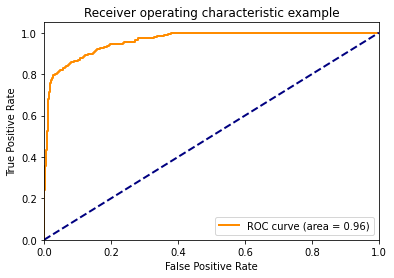

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
optimal_idx = np.argmin(np.sqrt((1-tpr)**2 + fpr**2))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.025292108


In [ ]:
predictions_train = np.array(sigmoid(predictions))
predictions_train[predictions_train > optimal_threshold] = 1
predictions_train[predictions_train <= optimal_threshold] = 0

In [ ]:
predictions_val[predictions_val > optimal_threshold] = 1
predictions_val[predictions_val <= optimal_threshold] = 0

In [ ]:
print(f'Validation accuracy score {accuracy_score(y_val, predictions_val)}')

Validation accuracy score 0.8927536231884058


Frames labels and video labels matching

In [ ]:
val_pred_frame = defaultdict(list)
val_pred_frame_true = defaultdict(list)
for pred, name, y in zip(predictions_val, val_frame_name, y_val):
  val_pred_frame[name.split('_')[0]].append(pred[0])
  val_pred_frame_true[name.split('_')[0]].append(y)

In [ ]:
train_pred_frame = defaultdict(list)
train_pred_frame_true = defaultdict(list)
for pred, name, y in zip(predictions_train, train_frame_name, y_train):
  train_pred_frame[name.split('_')[0]].append(pred[0])
  train_pred_frame_true[name.split('_')[0]].append(y)

In [ ]:
print("DTP\tFrames num\tTrueDTP\tvideoLabel")
for i, k in zip(range(0, 10), val_pred_frame.keys()):
  print(f'{sum(val_pred_frame[k])}\t{len(val_pred_frame[k])}\t\
          {sum(val_pred_frame_true[k])}\t{data.loc[int(k)].Label}')

DTP	Frames num	TrueDTP	videoLabel
212.0	212	          208	1
177.0	240	          237	1
0.0	166	          0	0
41.0	225	          0	0
0.0	192	          0	0


In [ ]:
print("DTP\tFrames num\tTrueDTP\tvideoLabel")
for i, k in zip(range(0, 400), train_pred_frame.keys()):
  print(f'{sum(train_pred_frame[k])}\t{len(train_pred_frame[k])}\t\
          {sum(train_pred_frame_true[k])}\t{data.loc[int(k)].Label}')

DTP	Frames num	TrueDTP	videoLabel
0.0	166	          0	0
234.0	234	          230	1
0.0	162	          0	0
187.0	187	          182	1
0.0	157	          0	0
0.0	152	          0	0
315.0	315	          315	1
0.0	154	          0	0
165.0	165	          157	1
0.0	158	          0	0
0.0	167	          0	0
0.0	155	          0	0
0.0	180	          0	0
204.0	204	          199	1
0.0	165	          0	0
194.0	194	          191	1
0.0	158	          0	0
5.0	159	          0	0
1.0	162	          0	0
6.0	176	          0	0
2.0	152	          0	0
1.0	141	          0	0
355.0	355	          346	1
103.0	103	          97	1
1.0	190	          0	0
0.0	165	          0	0
350.0	350	          350	1
142.0	142	          134	1
2.0	149	          0	0
5.0	86	          0	0
0.0	163	          0	0
80.0	80	          76	1
777.0	777	          777	1
233.0	233	          228	1
3.0	161	          0	0
309.0	309	          306	1
4.0	166	          0	0
0.0	160	          0	0
167.0	167	          167	1
200.0	200	          194	1
